### Import modules and libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import datetime as DT
from sklearn_pandas import DataFrameMapper
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from tensorflow.keras.layers import Dropout
import pickle
import dill

%matplotlib inline

### Read the 17_18 and 18_19 data

In [2]:
df_17_18 = pd.read_csv('data/season_17_18.csv')

df_17_18['home_win'] = df_17_18['home_win'].astype(bool)
df_17_18['home'] = df_17_18['home'].astype(int)
df_17_18['away'] = df_17_18['away'].astype(int)

df_17_18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454314 entries, 0 to 454313
Data columns (total 4 columns):
time        454314 non-null float64
home        454314 non-null int64
away        454314 non-null int64
home_win    454314 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 10.8 MB


In [3]:
df_18_19 = pd.read_csv('data/season_18_19.csv')

df_18_19['home_win'] = df_18_19['home_win'].astype(bool)
df_18_19['home'] = df_18_19['home'].astype(int)
df_18_19['away'] = df_18_19['away'].astype(int)

df_18_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482045 entries, 0 to 482044
Data columns (total 4 columns):
time        482045 non-null float64
home        482045 non-null int64
away        482045 non-null int64
home_win    482045 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 11.5 MB


### Combine both dataset

In [4]:
df = df_17_18.append(df_18_19)

In [5]:
df_no_duplicate = df.drop_duplicates()

In [6]:
df_no_duplicate.to_csv('data/combined_lite.csv')

In [7]:
len(df_no_duplicate)

776140

### Define X and y, and set a benchmark to beat for our model

In [8]:
# There are 58.65% chance home team will win and our model have to beat it
np.sum(df['home_win'])/len(df)

0.5865079526121926

### Do a train test split and feed it into models

In [9]:
features = ['time','home','away']
target = 'home_win'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [10]:
pca = PCA(n_components=3)
pca.fit(X_train)
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

In [11]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(Z_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
# Seems like logistic regression is better than the benchmark score. Now we optimize it
print(log_reg.score(Z_train, y_train))
print(log_reg.score(Z_test, y_test))

0.7381359564497365
0.7384638386945191


In [13]:
#Model params
model_params = {
    'penalty':['l1', 'l2'],
    'C':[0.01, 0.1, 1, 5, 15, 30],
    'random_state':[42],
    'solver': ['liblinear']
}

pipe_logreg = make_pipeline(
    PCA(n_components=3, random_state=42),
    GridSearchCV(log_reg, model_params, cv=3)
)

pipe_logreg.fit(X_train, y_train)

print(f"The score for train data is {pipe_logreg.score(X_train, y_train)}.")
print(f"The score for test data is {pipe_logreg.score(X_test, y_test)}.")

The score for train data is 0.7381202929361825.
The score for test data is 0.7384382075270195.


### Train with neural network

In [14]:
# input -> 500 -> 1000 -> 500 -> 1
model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [16]:
# Add early stopping rounds
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='acc', min_delta=0, patience=15)

In [18]:
# Fit model on training data.
history = model.fit(X_train,
                    y_train, 
                    batch_size=10000,
                    validation_data=(X_test, y_test),
                    epochs=500, 
                    callbacks=[early_stop]
                    )

Train on 702269 samples, validate on 234090 samples
Epoch 1/500
702269/702269 [==============================] - 30s 43us/sample - loss: 1.6724 - acc: 0.6443 - val_loss: 0.5157 - val_acc: 0.7250
Epoch 2/500
702269/702269 [==============================] - 29s 42us/sample - loss: 0.5204 - acc: 0.7265 - val_loss: 0.5130 - val_acc: 0.7301
Epoch 3/500
702269/702269 [==============================] - 29s 42us/sample - loss: 0.5147 - acc: 0.7315 - val_loss: 0.5091 - val_acc: 0.7351
Epoch 4/500
702269/702269 [==============================] - 29s 42us/sample - loss: 0.5111 - acc: 0.7350 - val_loss: 0.5073 - val_acc: 0.7369
Epoch 5/500
702269/702269 [==============================] - 30s 43us/sample - loss: 0.5085 - acc: 0.7368 - val_loss: 0.5041 - val_acc: 0.7379
Epoch 6/500
702269/702269 [==============================] - 31s 44us/sample - loss: 0.5069 - acc: 0.7369 - val_loss: 0.5053 - val_acc: 0.7389
Epoch 7/500
702269/702269 [==============================] - 30s 43us/sample - loss: 0.505

702269/702269 [==============================] - 30s 43us/sample - loss: 0.4931 - acc: 0.7403 - val_loss: 0.4911 - val_acc: 0.7411
Epoch 57/500
702269/702269 [==============================] - 31s 44us/sample - loss: 0.4928 - acc: 0.7402 - val_loss: 0.4969 - val_acc: 0.7416
Epoch 58/500
702269/702269 [==============================] - 30s 43us/sample - loss: 0.4926 - acc: 0.7405 - val_loss: 0.4923 - val_acc: 0.7405
Epoch 59/500
702269/702269 [==============================] - 30s 43us/sample - loss: 0.4930 - acc: 0.7405 - val_loss: 0.4921 - val_acc: 0.7411
Epoch 60/500
702269/702269 [==============================] - 30s 43us/sample - loss: 0.4928 - acc: 0.7405 - val_loss: 0.5019 - val_acc: 0.7411
Epoch 61/500
702269/702269 [==============================] - 30s 42us/sample - loss: 0.4930 - acc: 0.7404 - val_loss: 0.4960 - val_acc: 0.7417
Epoch 62/500
702269/702269 [==============================] - 31s 44us/sample - loss: 0.4925 - acc: 0.7405 - val_loss: 0.4975 - val_acc: 0.7412
Epoch

### Perform analysis on the model performance and test it with new data

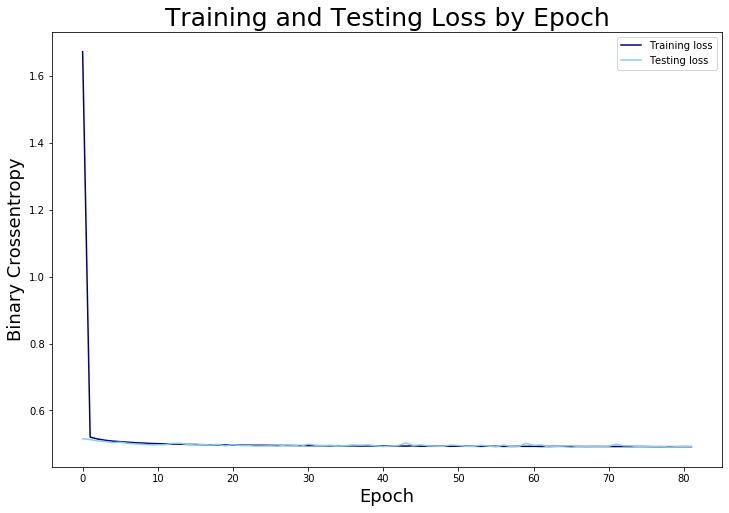

In [20]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.legend();

In [21]:
# time played, home score, visitor score
data = [[47,93,97]]
model.predict(data)

array([[0.19183572]], dtype=float32)

In [22]:
pipe_logreg.predict(data)

array([False])

### Pickle/Save the model and use it in app.py

In [19]:
# Save tensorflow model
model.save("model.h5")

In [ ]:
# Save logistic regression model
pickle.dump(pipe, open('logreg.pkl', 'wb'))